# Lab 13: Linear regression

This lab covers both simple and multiple linear regression.</B>

Below is our typical list of imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.stats import multivariate_normal
import csv
print 'Modules Imported!'

Modules Imported!


## Review from Lab 10: Covariance matrices and multivariate Gaussian distribution

In ECE 313 we consider the bivariate Gaussian distribution. Recall that we used the bivariate Gaussian distribution near the end of Lab 10 for modeling a hypothesis testing problem. It is a joint distribution for two random variables, $X_1,X_2$ and is uniquely determined by five parameters, the means of the two random variables, $m_1$ and $m_2$, the variances of the two random variables, and the covariance between the two random variables defined by $\mbox{Cov}(X_1,X_2)=E[(X_1-m_1)(X_2-m_2)].$ 
When we think of multidimensional distributions, we often use Cov(,) to describe all kinds of covariances. Note that $\mbox{Cov}(X_1,X_1)=\mbox{Var}(X_1)$ and $\mbox{Cov}(X_1,X_2)=\mbox{Cov}(X_2,X_1).$    Equivalently,
we can think of $\binom{X_1}{X_2}$ as a random vector, with  a mean vector $\binom{m_1}{m_2}$ and a covariance matrix
$\Sigma=\left( \begin{array}  \mbox{Cov}(X_1,X_1) & \mbox{Cov}(X_1,X_2)\\ \mbox{Cov}(X_2,X_1) & \mbox{Cov}(X_2,X_2) \end{array}\right).$ Based on our definitions shown above, it's clear that a covariance matrix is symmetric (i.e. $\Sigma^T = \Sigma$).  Joint normal (also known as joint Gaussian) distributions exist in any number of dimensions.   A Gaussian distribution in a given number of dimensions is specified uniquely by a mean vector and a covariance matrix.  The following code copied from Lab 10 generates variates for two normal distributions.  The orange triangles follow a distribution that is rotationally symmetric about the origin.   The blue circles follow a distribution with positive correlation between the two coordinates; the shape of the blue blob of points is elongated along a line of slope one.  Also, the mean vector for the blue points is $\binom{2.0}{0}$ so the blue blob is offset a bit to the right of the orange blob.

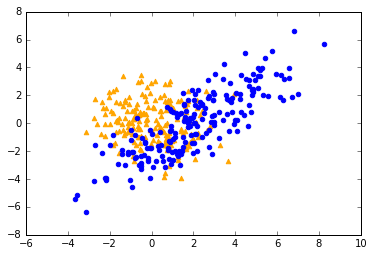

In [2]:
dim=2  # Dimension of the random vectors
num_samples=200
Sigma0=2.0*np.identity(dim)    # identity matrix
Sigma1=np.identity(dim)+ 4.0*np.ones([dim,dim])   # some positive correlation added
mu0=np.zeros(dim)
mu1=np.zeros(dim)
mu1[0]=2.0  # first coordinate has nonzero mean under H1
variates0= multivariate_normal.rvs(mu0,Sigma0,num_samples)
variates1= multivariate_normal.rvs(mu1,Sigma1,num_samples)
plt.scatter(variates0[:,0],variates0[:,1],color='orange',marker='^')
plt.scatter(variates1[:,0],variates1[:,1],color='blue')
# plt.plot.scatter(variates2)
plt.show()

# Simple linear regression, aka $\widehat{E}[Y|X]~$ based on data

Suppose we have a pair of correlated random variables, X and Y, and we wanted to estimate Y based on the observation of X. In doing this, we want to minimize the mean square error between Y and our estimate of Y. As seen in Section 4.9.2 of the ECE 313 notes, the estimator that achieves this is simply given by $E[Y|X]$. This can be difficult or impractical to calculate so we like to look at a linear estimator. As seen in Section 4.9.3 of the ECE 313 notes, the minimum mean square error linear estimator of a random variable $Y$ based on observation of a random variable $X$ is $\widehat{E}[Y|X]=L^*(X),$ where $L^*$ is the linear (actually, affine) function defined by $L^*(u)=\mu_Y + \frac{\mbox{Cov}(Y,X)}{\mbox{Var}(X)}(u-\mu_X).$   Often we don't have a known joint distribution of $X$ and $Y$ but we have a list of samples of $(X,Y)$ pairs, $((x_i,y_i): 0\leq i \leq n-1).$     We can use the same equations for the linear estimator $L$ by using the *empirical* joint distribution of $(X,Y),$  where the empirical joint distribution gives equal probability $1/n$ to each sample pair. Below is code that generates a lot of sample pairs from a joint Gaussian distribution and then finds the linear estimator of the Y coordinate based on the X coordinate. This is known as linear regression of the $Y$ values based on the $X$ values.

[[  4.02789375e+00   3.77518156e+00   5.31669113e+00   2.19575003e+00
   -1.68416085e-01   5.07479773e+00   5.34408716e+00   3.31890928e+00
    3.43511082e+00   1.71987058e+00   2.21143752e+00   4.72406946e+00
    3.76982590e+00   5.86497770e+00   4.35125346e+00   3.55477668e+00
    4.23778138e+00   1.45927525e+00   3.97956810e+00  -2.32162230e+00
    6.34437328e+00   4.90337895e+00   3.27827676e+00   5.10474953e+00
    3.45337032e+00  -1.28312275e-01   6.18833765e-01   2.12082367e+00
   -2.13062661e+00  -8.26879216e-01  -8.85450962e-01   2.81604894e+00
    4.21790123e+00   4.87301548e+00   5.72203015e-01   1.56260145e+00
    6.68732808e-01  -4.03509167e-01   3.08086682e+00  -1.26888948e-01
    2.94540643e+00   1.32674080e-01   1.47958400e+00   1.43989157e+00
    1.91870621e+00   2.66633551e+00   5.64522996e+00   4.63233582e+00
    1.51227622e+00   2.39011719e-01   3.67437430e-01   9.91287988e-01
    8.73420825e-02   5.59050544e+00   3.99593550e+00   3.92380615e+00
    3.01476407e+00  

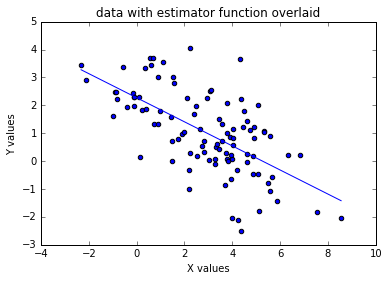

In [8]:
#######################
def linear_estimator(x,y):
# Given samples produce the optimal linear estimator Lstar(u)
# Note that this function returns a function
# Both the observations (the x's) and the values to be
# estimated (the y's) are assumed to be scalar valued.
    num_samples = len(x)
    assert len(x)==len(y), "number of x values unequal to number of y values"
    ave_x = np.average(x)
    ave_y = np.average(y)
    var_x = np.average(x*x)-ave_x**2
    cov_xy = np.average(x*y)-ave_x*ave_y
    
    a = cov_xy/var_x
    b = ave_y-ave_x*a
    
    def Lstar(u):     # Define the function to be returned
        return a*u+b
    
    return  Lstar;
#########################

num_samples=100

###  Randomly generate synthetic data using a joint Gaussian distribution
Sigma=np.array([[4,-2],[-2,2]])  #Covariance matrix
mu=np.array([3,1]) #Mean matrix
data = multivariate_normal.rvs(mu,Sigma,num_samples).T   #shape=(2,num_samples)
# Think of the first row of data as the X values, to be observed, and the second
# row of data as the Y values, to be estimated.
print data

Lstar = linear_estimator(data[0,:],data[1,:])  #  Produces Lstar, a linear function of one variable

u=np.linspace(min(data[0,:]),max(data[0,:]),1000) #From the minimum of the row of X values to the maximum
plt.plot(u,Lstar(u)) #This is creating a line
plt.scatter(data[0,:],data[1,:]) #This is creating the dots
plt.title('data with estimator function overlaid')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.show()

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>**  We can similarly compute $\widehat{E}[X|Y]$,  which gives a linear estimate of $X$ as a function of $Y.$  

1. Calculate the estimator $\widehat{E}[X|Y]$.
2. Plot it on the same set of axes as $\widehat{E}[Y|X].$    
3. Does it give the same linear relationship between $X$ and $Y$ that $\widehat{E}[Y|X]$ does?  Explain or prove your answer in general for two random variables $X$ and $Y$?

[[ -2.10751986e-01  -5.10058904e-01   1.93346358e+00  -1.35737273e-01
   -6.21585763e-01   9.37443506e-01  -1.02502421e+00   2.15914193e+00
    7.40380876e-01  -1.74469305e-01  -1.12304197e+00   3.01201317e+00
    1.19214860e+00   1.32679245e+00   2.01012502e+00   8.32453047e-03
    1.39744634e+00  -1.78956031e-01   1.49977809e+00   3.61164391e+00
    2.06820574e-01  -2.14413107e-01   7.65077905e-02   4.77915793e-01
   -2.64235506e-01   1.98477313e+00   9.27078408e-01   3.22659792e-01
    3.38857564e+00   1.73755744e+00   3.54122072e-01   6.36346208e-01
    1.25490249e+00  -2.59895353e-01  -6.16945581e-01   3.46322849e-01
    1.62002993e+00   1.15119551e+00  -1.22682062e+00  -4.49626394e-02
    2.00876425e+00   9.67123740e-01   2.38293394e+00   8.06554795e-01
   -9.24384214e-01   1.85255868e+00  -1.99169435e+00   6.92080953e-01
    2.03207426e+00   2.03080897e+00   3.01925138e+00  -4.41244792e-01
   -5.78551151e-02   3.75108340e+00  -1.51653086e+00   1.22132378e+00
    2.59686266e+00  

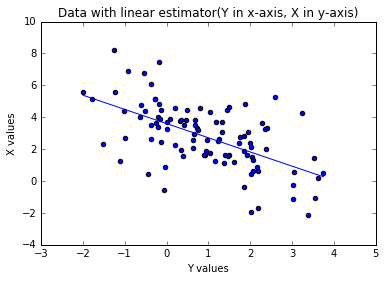

<function matplotlib.pyplot.show>

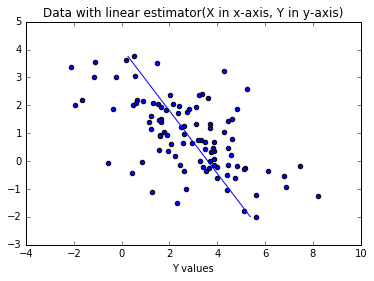

In [20]:
# Your code here

# The function is given above
num_samples = 100

Sigma = np.array([[2,-2],[-2,4]])  #Covariance matrix(X,Y)
mu = np.array([1,3])
data1 = multivariate_normal.rvs(mu,Sigma,num_samples).T
print data1
Lstar1 = linear_estimator(data1[0,:],data1[1,:])
u1 = np.linspace(min(data1[0,:]), max(data1[0,:]),1000)
plt.figure(0)
plt.plot(u1, Lstar1(u1)) #plot the line
plt.scatter(data1[0,:],data1[1,:]) #plot the scatter data
plt.xlabel('Y values')
plt.ylabel('X values')
plt.title('Data with linear estimator(Y in x-axis, X in y-axis)')
plt.show()

##############
#Plot it in X->x axis, Y->y axis
plt.figure(1)
plt.plot(Lstar1(u1),u1)
plt.scatter(data1[1,:],data1[0,:])
plt.xlabel('X values')
plt.xlabel('Y values')
plt.title('Data with linear estimator(X in x-axis, Y in y-axis)')
plt.show

__Answer:__ (Your answer here)
3. Yes, the relationship is the still.  It still obeys the linear estimator, however, with different slope due to the denominator difference.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

# Linear predictors for ECE 313 final exam scores

The following code loads some scores from a CSV file.  Each row in the file corresponds to four scores for a particular student: quiz sum, Exam 1, Exam 2, and final exam, for ECE 313 at the University of Illinois in Spring 2013. (The quiz sum is the sum for all 12 quizzes with no dropping of three lowest quiz scores.) The function data_load() takes a transpose, so that each column of the numpy array returned by the function corresponds to one student.

In [21]:
#  From .csv file, read headers, then load numbers into array x
#  Warning: unfortunately there are many types of .csv files
#  This code assumes the .csv file has comma separate headings in the first row
#  and comma separated numbers in the remaining rows.
def data_load(string):
    csv_path = string
    with open(csv_path,'rb') as csvfile:  #After code under "with open as" is completed, csvfile is closed
        reader=csv.reader(csvfile)
        headings=reader.next()
        print "Reading csv file with headers:\n  ","\n   ".join(headings),"\n"
        x=[]
        for row in reader:
            x.append(row)    
    return(np.array(x,dtype=float).T)   # returns data with one column for each multidimensional sample

print "Function loaded"

Function loaded


Let's load the ECE 313 scores, and calculate the sample covariance matrix and sample correlation matrix. Recall that the correlation coefficient between two random variables $X$ and $Y$ is given by $\rho_{X,Y} = \frac{\mbox{Cov}(X,Y)}{\sigma_X \sigma_Y}.$    The correlation matrix is the matrix of correlation coefficients.  (``Correlation coefficient matrix," would be a more accurate name but it's too long to use.)

In [26]:
# Calculate mean vector, covariance matrix, and correlation matrix for empirical distribution
#
x=data_load("313scores.csv")
mean_x=np.mean(x,axis=1).reshape(-1,1)   # return mean as 4x1 column vector
      # -1 means "unspecified value," the value is inferred to be 4 for the 313scores data
covariance_matrix = np.dot(x-mean_x,(x-mean_x).T)/(x.shape[1])
print "mean=", '\n', mean_x, '\n\n', "covariance matrix=",'\n',covariance_matrix,'\n'

variances=np.diag(covariance_matrix).reshape(-1,1)  # column vector of variances
std_dev=np.sqrt(variances)    # vector of stdev's

print "variances=  (diagonal entries of the covariance matrix)", '\n', \
        variances,'\n\n', "standard deviations=",'\n', std_dev, '\n'

correlation_matrix=covariance_matrix/std_dev/std_dev.T
      # In numpy, division of a matrix (a_ij) by a row vector (v_j) divide a_ij by v_j
      # and division of (a_ij) by a column vector (v_i) divides a_ij by v_i
print "correlation matrix=  (i.e. matrix of correlation coefficients)",'\n', correlation_matrix,'\n'

Reading csv file with headers:
   quiz sum
   Exam 1
   Exam 2
   Final 

mean= 
[[  80.63084112]
 [  70.61214953]
 [  61.54205607]
 [ 105.64018692]] 

covariance matrix= 
[[  595.74689929    97.74467202   143.44309547   399.15221853]
 [   97.74467202   274.2000393    193.35042362   385.21091362]
 [  143.44309547   193.35042362   411.60337147   534.11559962]
 [  399.15221853   385.21091362   534.11559962  1279.00604856]] 

variances=  (diagonal entries of the covariance matrix) 
[[  595.74689929]
 [  274.2000393 ]
 [  411.60337147]
 [ 1279.00604856]] 

standard deviations= 
[[ 24.40792698]
 [ 16.55898666]
 [ 20.28801054]
 [ 35.76319405]] 

correlation matrix=  (i.e. matrix of correlation coefficients) 
[[ 1.          0.24184017  0.28967385  0.45726857]
 [ 0.24184017  1.          0.57553523  0.65047188]
 [ 0.28967385  0.57553523  1.          0.73613845]
 [ 0.45726857  0.65047188  0.73613845  1.        ]] 



Let's see what the mean error is for estimating the score on the final from any one of the other three scores. Here we recall from the ECE 313 notes (Section 4.9.3) that to estimate a random variable $Y$ from a random variable $X,$  the minimum mean square error linear estimator is given by
$$ \widehat{E}[Y | X] =L^*(X) = E[Y] +\frac{ \mbox{Cov}(Y,X) }{\mbox{Var}(X) } (X-E[X])$$
$$= E[Y] + \frac{\sigma_X \sigma_Y \rho_{X,Y}}{\sigma_X^2} \left(X-E[X]\right)$$
$$= E[Y] + \sigma_Y \rho_{X,Y} \left( \frac{X-E[X]}{\sigma_X } \right)$$
and the mean square error is given by:
$$E[(Y-\widehat{E}[Y | X])^2] = \mbox{Var}(Y) - \frac{ \mbox{Cov}(Y,X)^2}{ \mbox{Cov}(X,X)} = \sigma_Y^2(1-\rho_{X,Y}^2),$$   where $ \rho_{X,Y} $ is the correlation coefficient between $X$ and $Y.$
To apply these equations to our data, we can choose any one of the first three scores to represent $X$  and the final exam score to represent $Y.$  So we could estimate the final score from any of the other three scores.  In the code below we don't actually calculate the linear estimators (though it could be easily done, using the function linear\_estimator() we defined above).   Instead, we just use the formula for the minimum MSE to see what the mean square error is for each of the three possible choices of data X (i.e. for X=quiz scores, X=exam 1 scores, or X=exam 2 scores).  To get a better idea of what the MSE means, we also calculate the square root of the MSE  (i.e. the standard deviation of error) for each of the three linear estimators.

In [24]:
# Calculate mean square error and root mean square error for predicting
# score on final exam by using any one of the first three scores
# Think of Y as representing final exam score, the fourth coordinate of the data vector x
EY=mean_x[3]
CorYX=correlation_matrix[3,0:3]  # correlation coefficients between Y and other three scores and itself
VarY=covariance_matrix[3,3]
print "Mean square errors =", VarY *(1-CorYX**2)
print  "sqare roots of MSEs", np.sqrt(VarY*(1-CorYX**2))

Mean square errors = [ 1011.57285881   737.84110801   585.91290715]
sqare roots of MSEs [ 31.8052332   27.16323081  24.20563792]


The above code shows that, of the three possibilities, the score on exam 2 is the best single predictor of the final exam score, and the standard deviation of the error for that estimator is about 24.

Let's see how well the final exam score can be predicted by *combining* all three of the earlier scores, instead of just using one of them.  This is called *multiple linear regression.*  It turns out that the expressions above for best linear estimator extend to the case $X$ is vector valued.  ($Y$ can also be vector valued, but in that case, the estimation amounts to estimating each coordinate of $Y$ separately, anyway.)  If a random variable $Y$ is to be estimated from a
random vector $X,$ the minimum mean square error linear estimator is given by
$$ \widehat{E}[Y | X] = E[Y] + \mbox{Cov}(Y,X) \mbox{Cov}(X,X)^{-1} (X-E[X]) $$
and the mean square error is given by:
$$E[(Y-\widehat{E}[Y | X])^2] = \mbox{Var}(Y) -  \mbox{Cov}(Y,X) \mbox{Cov}(X,X)^{-1} \mbox{Cov}{(X,Y)}.$$
Here, $\mbox{Cov}{(X,Y)}$ is a matrix with $i,j^{th}$ entry equal to $\mbox{Cov}(X_i,Y_j).$  Note that
$( \mbox{Cov}{(X,Y)})^T =  \mbox{Cov}{(Y,X)}.$   

To apply these equations to the numerical data, we think of the vector $X$ as the scores on the first three exams, and $Y$ as the score on the final exam.

In [30]:
EX=mean_x[0:3]
EY=mean_x[3]
CovXX=covariance_matrix[0:3,0:3]
CovXY=covariance_matrix[0:3,3]
CovYX=covariance_matrix[3,0:3]
print "Cov(Y,X)=", CovYX
# assert all(CovXY==CovYX.T), "CovXY is not the transpose of CovYX"
VarY=covariance_matrix[3,3]

print "weight vector=", np.dot(CovYX,np.linalg.inv(CovXX)) #This is the slope vector of Lstar
print "the constant=", EY- np.dot( np.dot(CovYX,np.linalg.inv(CovXX)),EX) #This is the constant of Lstar

MSE= VarY -np.dot(CovYX,np.dot(np.linalg.inv(CovXX),CovXY))
print "MSE for multiple regression", MSE, "square root of MSE",np.sqrt(MSE)


Cov(Y,X)= [ 399.15221853  385.21091362  534.11559962]
weight vector= [ 0.35281047  0.6740237   0.85807025]
the constant= [-23.20888712]
MSE for multiple regression 420.230979293 square root of MSE 20.4995360751


So the best linear estimator of the final exam score given the first three scores is
$$\widehat{E}[\mbox{final exam }|\mbox{ other scores}]= (0.35)(\mbox{quiz sum})+(0.67)(\mbox{exam_1})+(0.85)(\mbox{exam_2}) - 23.2$$ and the sqare root of the MSE (when applied to the data) is about 20.5.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>** Go through a similar process as above for predicting the sale price, Y, of housing in Los Angeles based on other factors such as number of bedrooms, square feet, etc.    Specifically, load the data from the file HousingPrices.csv, which has the data from the paper S.C. Narula and J.F. Wellington "Prediction, Linear Regression, and Minimum Sum of Relative Error,"  *Technometrics*, vol. 19, no. 2, May 1977, pp. 185-190.  Then:
<ol>
<li> Determine the minimum mean square error (MMSE) for estimation of $Y$ based on any one of the other numbers.  That is, for the MMSE for linear estimation of the sale price by the number of bathrooms, and the MMSE for estimation of the sale price by the inside square footage, etc.   Which of the other indicators gives the most accurate prediction of the sale price?
<li> Find the MMSE linear estimator for estimation of $Y$ based on using all the other numbers combined. That is, find the weight vector and constant of the estimator.   Also, find the resulting value of the MSE. 

In [31]:
# Your code here
#12 instances
#First load the data
# Calculate mean vector, covariance matrix, and correlation matrix for empirical distribution
#
x=data_load("HousingPrices.csv")
mean_x=np.mean(x,axis=1).reshape(-1,1)   # return mean as 12x1 column vector
      # -1 means "unspecified value," the value is inferred to be 12 for the HousingPrices data
covariance_matrix = np.dot(x-mean_x,(x-mean_x).T)/(x.shape[1])
print "mean=", '\n', mean_x, '\n\n', "covariance matrix=",'\n',covariance_matrix,'\n'

variances=np.diag(covariance_matrix).reshape(-1,1)  # column vector of variances
std_dev=np.sqrt(variances)    # vector of stdev's

print "variances=  (diagonal entries of the covariance matrix)", '\n', \
        variances,'\n\n', "standard deviations=",'\n', std_dev, '\n'

correlation_matrix=covariance_matrix/std_dev/std_dev.T
      # In numpy, division of a matrix (a_ij) by a row vector (v_j) divide a_ij by v_j
      # and division of (a_ij) by a column vector (v_i) divides a_ij by v_i
print "correlation matrix=  (i.e. matrix of correlation coefficients)",'\n', correlation_matrix,'\n'

Reading csv file with headers:
   Local Taxes (hundreds of dollars)
   Number of Bathrooms
   Lot Area (thousands sq feet)
   Living Space (thousands sq feet)
   Numer of Garages
   Number of Rooms
   Number of Bedrooms
   Age (years)
   Material
   Type
   Number of Fire Places
   Selling Price 

mean= 
[[  7.22185357]
 [  1.26785714]
 [  6.46085714]
 [  1.51167857]
 [  1.33928571]
 [  6.67857143]
 [  3.28571429]
 [ 36.32142857]
 [  2.25      ]
 [  1.21428571]
 [  0.32142857]
 [ 38.15714286]] 

covariance matrix= 
[[  8.42870060e+00   1.05307672e+00   4.35762380e+00   1.31241809e+00
    9.56887181e-01   2.47582436e+00   1.32664898e+00  -1.35022851e+01
    5.13383036e-01   9.27563776e-02   6.66907781e-01   3.72579012e+01]
 [  1.05307672e+00   1.69323980e-01   5.73818622e-01   1.97907526e-01
    1.05548469e-01   3.53954082e-01   2.09183673e-01  -1.12181122e+00
    9.37500000e-02  -5.73979592e-02   9.24744898e-02   5.29183673e+00]
 [  4.35762380e+00   5.73818622e-01   5.71157693e+00   8.

In [32]:
# Calculate mean square error and root mean square error for predicting
# score on final exam by using any one of the first three scores
# Think of Y as representing final exam score, the fourth coordinate of the data vector x
n = 12
EY=mean_x[n-1]
CorYX=correlation_matrix[n-1,0:n-1]  # correlation coefficients between Y and other three scores and itself
VarY=covariance_matrix[n-1,n-1]
print "Mean square errors =", VarY *(1-CorYX**2)
print  "sqare roots of MSEs", np.sqrt(VarY*(1-CorYX**2))

Mean square errors = [  28.56335311   27.87238633  107.38796413   29.09665536  152.06157685
   76.53857002   98.41039062  175.9450102   187.49174768  193.16061475
  146.84583124]
sqare roots of MSEs [  5.34446939   5.27943049  10.36281642   5.39413157  12.33132502
   8.74863247   9.92020114  13.26442649  13.6927626   13.89822344
  12.11799617]


In [33]:
EX=mean_x[0:n-1]
EY=mean_x[n-1]
CovXX=covariance_matrix[0:n-1,0:n-1]
CovXY=covariance_matrix[0:n-1,n-1]
CovYX=covariance_matrix[n-1,0:n-1]
print "Cov(Y,X)=", CovYX
# assert all(CovXY==CovYX.T), "CovXY is not the transpose of CovYX"
VarY=covariance_matrix[n-1,n-1]

print "weight vector=", np.dot(CovYX,np.linalg.inv(CovXX)) #This is the slope vector of Lstar
print "the constant=", EY- np.dot( np.dot(CovYX,np.linalg.inv(CovXX)),EX) #This is the constant of Lstar

MSE= VarY -np.dot(CovYX,np.dot(np.linalg.inv(CovXX),CovXY))
print "MSE for multiple regression", MSE, "square root of MSE",np.sqrt(MSE)


Cov(Y,X)= [ 37.25790122   5.29183673  22.14601745   6.89263265   4.11811224
  12.26836735   6.81581633 -56.4505102    2.91428571  -0.17295918
   3.18163265]
weight vector= [  0.84203461   9.13727309   0.1805502   13.31511517   1.93053047
  -1.07030169  -0.30201195  -0.07198748   1.02264378   1.33991086
   2.78686263]
the constant= [ 2.54245911]
MSE for multiple regression 9.31681120162 square root of MSE 3.05234519699


__Answer__: (Your answer here)
1. For the first problem the second instance, which is the number of bathrooms, is the best estimator.
2. For the second problem we get the MSE to be around 9.32, and the square root of MSE is around 3.05.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 